William and Omar

In [14]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline


# Lab: Applying Reinforcement Learning (DQN) 
**Author**: [Adam Paszke](https://github.com/apaszke)
            [Mark Towers](https://github.com/pseudo-rnd-thoughts)
            Jingsai Liang


This lab is to use PyTorch to train a Deep Q Learning (DQN) agent for solving Pong game. 

Please visit the step one of your Pong project and answer following questions. 

Question 1: What observations can the agent collect at each step of the game? The position of the paddle, the position of the ball, and the velocity of the ball

Question 2: What actions can the agent take after receving the observation? Paddle going up or down

Question 3: What rewards do the agent receive during the game? - absolute value of paddle distance plus 100, +10000 for a win, -10000 for a loss

Question 4: When will the game terminate or truncate? Every 10 games

We'll also use the following from PyTorch:

-  neural networks (``torch.nn``)
-  optimization (``torch.optim``)
-  automatic differentiation (``torch.autograd``)


We'll **upload PongAIvAI_PlayInBackground_DQN.py and chaser_ai.py** to the folder on the left side. Please remember that any modification you made on this file on colab is temporary. You need to save a copy of your modified file. So, I suggest you make your **change on PongAIvAI_PlayInBackground_DQN on your local laptop** and only upload it to here. 

**Before running any codel below, please modify the reward strategy in PongAIvAI_PlayInBackground_DQN.py.**


**If you do modify the reward code, you need to restart the running time and import PongAIvAI_PlayInBackground_DQN again.** Otherwise, you are still using the previous reward code. 

You may also change other parts of the code in the class Pong as well. For example, **you may change the state** to pass along other data and more history data of the paddle and the ball to the network. 


## Environment

### Reward

Do not use a complex reward strategy. You should consider

- Huge positve reward like 10,000 if winning a game
- Huge negative reward like -10,000 if losing a game
- Penalty based on the vertical difference between the ball and your paddle.

### State 

You can replace the raw state by your own processed state like

- the vertical middle position of your paddle
- the vertical middle position of the enemy paddle
- the current x and y positions of the ball
- the previous x and y positions of the ball (history information)
- the hight and width of the table

## Parameters  

### Nnumber of hidden layer 
  - Keep only one hidden layer

### Number of neurons

The number of neurons depends on the difficulty level of the agent. In general, you should use more neurons like 64, 128 or even more neurons if the enemy AI is a strong one. And, you only need fewer neurons like 32 if the enemy AI is a dummy one. 

Your model is easy to get overfitting if you use more neurons than you should use. And your model will not perform well if you use less neurons than you shoud use either. 

### tau of target network 
tau is a value to control the stability of the target network. If the orange curve in your training is not stable, you may reduce tau to a very tiny number. 

### Learning rate
Use a very tiny learning rate. 

### eps decay 
Slow down the eps decay by increasing EPS_DECAY.  

### Memory size 

Since the state space and action space is small, we need to have a large memory size to hold both good and bad sample. 

## Training 

### Catastrophic drop 

This means your network is not stable at all. You may try to 

- decrease tau
- decrease learning rate
- increase memory size
- decrease eps_decay
- increase number of neurons
- increase the batch size 

![](https://cs.westminstercollege.edu/~jingsai/courses/CMPT301/project/Pong_step2/images/catastrophic_drop_model_16.png)

### Peak and stop improving 

This means your network achieves the best performance on current setting. You may try to 

1. resume the training right before the peak value using one checkpoint

2. stop training loop when the orange curve climbing up to the peak value. 

3. save the best model to google drive

4. test the best model. 

![](https://cs.westminstercollege.edu/~jingsai/courses/CMPT301/project/Pong_step2/images/model19-1051.png)







## Expectation 

### Always up agent

- win 100% of time. 

![](https://cs.westminstercollege.edu/~jingsai/courses/CMPT301/project/Pong_step2/images/model10-dummy.png)

### chaser ai agent

- win over 70% of time.

![](https://cs.westminstercollege.edu/~jingsai/courses/CMPT301/project/Pong_step2/images/model19-351-bin.png)

In [15]:
from PongAIvAI_PlayInBackground_DQN_v3 import Pong

In [16]:
# import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

env = Pong() 

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Replay Memory

We'll be using experience replay memory for training our DQN. It stores
the transitions that the agent observes, allowing us to reuse this data
later. By sampling from it randomly, the transitions that build up a
batch are decorrelated. It has been shown that this greatly stabilizes
and improves the DQN training procedure.

For this, we're going to need two classses:

-  ``Transition`` - a named tuple representing a single transition in
   our environment. It essentially maps (state, action) pairs
   to their (next_state, reward) result, with the state being the
   screen difference image as described later on.
-  ``ReplayMemory`` - a cyclic buffer of bounded size that holds the
   transitions observed recently. It also implements a ``.sample()``
   method for selecting a random batch of transitions for training.




In [17]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

## DQN

Now, let's define our model. 

You need to define and change the structure of your network 
for training a better result such as:
  
- number of layers
- number of neurons on layers
- activation functions



In [18]:
# It requires a flatten layer since the input is a stacked of 4 states. 

class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.flatten = nn.Flatten()
        self.layer1 = nn.Linear(n_observations * 4, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

## Training

### Hyperparameters 



In [19]:
"""You may change these hyperparameters to tune your training. """
"""You need to initialize these hyperparameters to tune your training. 
Replace None by numbers. 
"""

# Total number of episodes for training
num_episodes = 78
# which episode to resume training 
start_episode = 76 
# BATCH_SIZE is the number of transitions sampled from the replay buffer
BATCH_SIZE = 128
# GAMMA is the discount factor as mentioned in the previous section
GAMMA = 0.99
# LR is the learning rate of the AdamW optimizer
LR = 1e-4 / 2
# Size of the replay memory 
MEMORY_SIZE = 10000
# TAU is the update rate of the target network
TAU = 0.0005

# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000

### Utilities
This cell instantiates our model and its optimizer, and defines some
utilities.


In [20]:
# Get number of actions from gym action space
n_actions = 2 # two actions
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(MEMORY_SIZE)

steps_done = 0
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        # return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)
         return torch.tensor([[np.random.randint(2)]], device=device, dtype=torch.long)

episode_scores = []
def plot_scores(show_result=False):
    plt.figure(1)
    scores_t = torch.tensor(episode_scores, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Scores')
    plt.plot(scores_t.numpy())
    # Take 50 episode averages and plot them too
    if len(scores_t) >= 50:
        means = scores_t.unfold(0, 50, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(49), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

# https://medium.com/analytics-vidhya/saving-and-loading-your-model-to-resume-training-in-pytorch-cb687352fa61
# https://pytorch.org/tutorials/recipes/recipes/saving_and_loading_a_general_checkpoint.html

def save_checkpoint(policy_net_state_dict, target_net_state_dict, optimizer_state_dict, i_episode, steps_done, episode_scores):
    PATH = folder_path + model_name + "_checkpoint_" + str(i_episode) + ".pth"
    torch.save({
            'epoch': i_episode, # to resume from i_episode
            'policy_net_state_dict': policy_net_state_dict,
            'target_net_state_dict': target_net_state_dict,
            'optimizer_state_dict': optimizer_state_dict,
            'steps_done': steps_done, # eps 
            'episode_scores': episode_scores # visualization of training 
            }, PATH)
    
def load_checkpoint(policy_net, target_net, optimizer, file_path):
    if device.type == "cuda":
        checkpoint = torch.load(file_path)
    else:
        checkpoint = torch.load(file_path, map_location=torch.device('cpu') )
    policy_net.load_state_dict(checkpoint['policy_net_state_dict'])
    target_net.load_state_dict(checkpoint['target_net_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    steps_done = checkpoint['steps_done']
    episode_scores = checkpoint['episode_scores']

    return policy_net, target_net, optimizer, epoch, steps_done, episode_scores

  
# from https://github.com/deepanshut041/Reinforcement-Learning/tree/master/cgames/01_ping_pong
def stack_state(stacked_states, state, is_new):
    # is_new: Is the state First
    if is_new:
        stacked_states = np.stack(arrays=[state, state, state, state])
        stacked_states = stacked_states
    else:
        stacked_states[0] = stacked_states[1]
        stacked_states[1] = stacked_states[2]
        stacked_states[2] = stacked_states[3]
        stacked_states[3] = state
    
    return stacked_states

def stack_states(states, state, is_new):
    states = stack_state(states, state, is_new)
    return states

# test 
# state = (1,2,3,4)
# states = stack_states(None, state, True)
# states = stack_states(states, [2,3,4,5], False)
# stack_states(states, [0,0,4,5], False)

### Optimize_model

Finally, the code for training our model.


In [21]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    
    # print("here",batch.state[0])

    state_batch = torch.cat(batch.state) # stack the state vertically row by row. the size is 128*4. 
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # print(state_batch.shape)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

Below, you can find the main training loop. At the beginning we reset
the environment and obtain the initial ``state`` Tensor. Then, we sample
an action, execute it, observe the next state and the reward, and optimize our model once. When the episode ends (our model
fails), we restart the loop.

Training RL agents can be a noisy process, so restarting training
can produce better results if convergence is not observed.




### Checkpoints


Before training your mode, you need to run the code below to mount your drive to this notebook, since you need to save checkpoints to your goodle drive.

In [22]:
from google.colab import drive
drive.mount('/content/drive')

# Force to mount again even though the drive has been already mounted.
# drive.mount('/content/drive',force_remount=True)

# disconnect the mount 
# drive.flush_and_unmount()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Parameters to adjust for saving and loading checkpoints.

In [23]:
# The folder in the google drive to save the checkpoints
folder_path = "/content/drive/My Drive/CMPT 301/Pong/"
# The name of your model
model_name = "chaser_v1"
# Frequency to save the checkpoints.
freq = 25 # Save one checkpoint every freq episodes. 

**This is the code to load a checkpoint and resume the training.**

**Do not run the code below unless you want to load previous checkpoint.** Otherwise, the model loaded will overlap the current model.

**You need to change episode_to_load and model name, and may restart the running time before load a checkpoint.**

In [24]:
"""
Uncomment the code below to load a check point and resume the training. 
"""

episode_to_load = '76' # adjust this number to the number of the checkpoint you want to resume

file_path = folder_path + model_name + "_checkpoint_" + episode_to_load + ".pth"

policy_net, target_net, optimizer, start_episode, steps_done, episode_scores = load_checkpoint(policy_net, target_net, optimizer, file_path)

### Training loop

In one episode, the agent wins the game if it scores 10 at first. 

In the dynamic picture showing the training results, your agent wins one episode if the value of the curve is above 0.5. Your agent loses one episode otherwise. 

A more detailed explanation of the score is here:

In [25]:
import pandas as pd

a = list(range(10)) + [10]*10
b = [10]*10 + list(range(9,-1,-1))
df = pd.DataFrame({"Your DQN Agent":a, "Enemy Agent":b})
df["score"]=round(df.iloc[:,0]/(df.iloc[:,0]+df.iloc[:,1]),2)
df

,Your DQN Agent,Enemy Agent,score
0,0,10,0.00
1,1,10,0.09
2,2,10,0.17
3,3,10,0.23
4,4,10,0.29
5,5,10,0.33
6,6,10,0.38
7,7,10,0.41
8,8,10,0.44
9,9,10,0.47


Complete


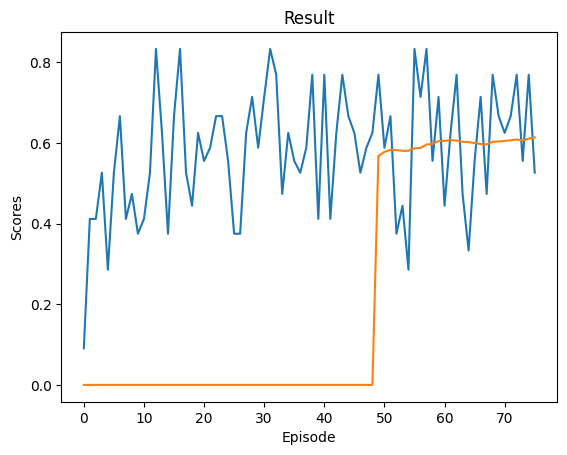

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [26]:
for i_episode in range(start_episode, num_episodes):
    # Initialize the environment and get it's state
    state, info = env.reset()
    state = stack_states(None, state, True) # stacked before unsqueeze 
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    while True: 
        action = select_action(state)
        observation, reward, terminated, truncated, score = env.step(action.item())

        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if device.type == "cuda": # Use this line if using GPU
          observation = stack_states(state.squeeze().cpu().numpy(), observation, False) # stacked before unsqueeze
        else:
          observation = stack_states(state.squeeze().numpy(), observation, False) # stacked before unsqueeze
        
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_scores.append(score[0]/sum(score)) # win if larger than 0.5. lose otherwise. 
            plot_scores()
            break

        """"check point code
        save check point every freq episodes
        save policy net, target net, optimizer, episode number to google drive.
        """
        if not i_episode%freq:
            optimizer_state_dict = optimizer.state_dict()
            save_checkpoint(policy_net_state_dict, target_net_state_dict, optimizer_state_dict, 
                            i_episode+1, steps_done, episode_scores)

print('Complete')
plot_scores(show_result=True)
plt.ioff()
plt.show()

## Save and load model after completing training.

Do not forget to save your model to your own goodle drive if you get a good model. Otherwise, you need to train your network again to get it. 



### Save mode

Change the last filename in the path to save it. 

In [27]:
torch.save(policy_net, '/content/drive/My Drive/CMPT 301/Final Models/'+model_name+'_76.pth')

### Load mode

Load your mode without training the network. You need to make sure that the structure of the network you defined earlier in this notebook must match the model you are loading here. 

If the model was trained in GPU while the running time is CPU now, you need to add `map_location=torch.device('cpu')` in `torch.load` to change the device. 

In [29]:
policy_net = torch.load('/content/drive/My Drive/CMPT 301/Final Models/'+model_name+'_76.pth')

# train i GPU, load on CPU
# policy_net = torch.load('/content/drive/My Drive/Colab Notebooks/CMPT301-AI/Pong/Models/model.pth', map_location=torch.device('cpu'))

## Testing

### Testing through statistics

Run your agent 100 times of episodes. 

An episode is considered a solution if it scores at least 50%.

Calculate the average rewards and the percetage of solutions. 

In [30]:
def select_action_testing(state):
    with torch.no_grad():
        return policy_net(state).max(1)[1].view(1, 1)

In [31]:
scores_list = []

for i in range(100):
    
    env = Pong()  
    obs, info = env.reset()
    obs_stack = stack_states(None, obs, True) # stacked before unsqueeze 
    while True:
        obs_stack = torch.tensor(obs_stack, dtype=torch.float32, device=device).unsqueeze(0)
        action = select_action_testing(obs_stack)
        obs, reward, terminated, truncated, score = env.step(action.item())
        
        if device.type == "cuda": # Use this line if using GPU
          obs_stack = stack_states(obs_stack.squeeze().cpu().numpy(), obs, False) # stacked before unsqueeze
        else:
          obs_stack = stack_states(obs_stack.squeeze().numpy(), obs, False) # stacked before unsqueeze

        if terminated or truncated:
            break
    if not i%10:
        print(i, "/100 completed.")

    scores_list.append(score.copy())

scores_list = np.array(scores_list)

0 /100 completed.
10 /100 completed.
20 /100 completed.
30 /100 completed.
40 /100 completed.
50 /100 completed.
60 /100 completed.
70 /100 completed.
80 /100 completed.
90 /100 completed.


**Goal 1**

This is the average of scores of your agent in 100 games. Score 10 means your agent wins one game. Score x (x<10) means your agent loses one game with x:10.

Your goal is to improve the average_score towards a perfect value 10.

In [32]:
average_score = np.mean(scores_list[:,0])
average_score

9.69

**Goal 2**

This is the average of scores of your agent divided by the total scores of both agents in 100 games. For example, 1 means your agent wins one game with 10:0. 

Your goal is to improve the average_score towards a perfect value 1.

In [33]:
average_score_total = np.mean(scores_list[:,0]/np.sum(scores_list, 1))
average_score_total

0.6559742768411497

**Goal 3**

This is the percentage that your agent wins the game in 100 games.

Your goal is to improve the percentage towards a perfect value 1.

In [34]:
# percentage of winning episodes 
percentage = np.sum(scores_list[:,0]==10)/100
percentage

0.89

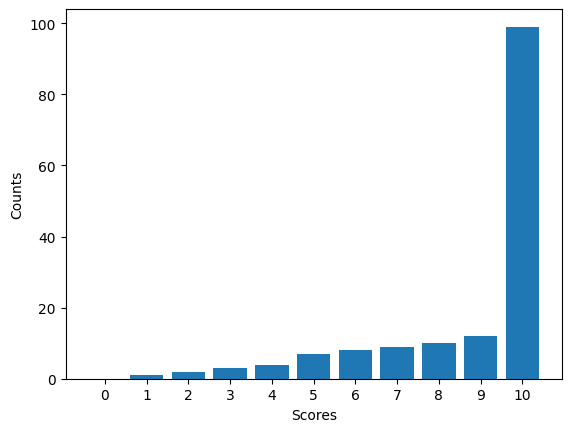

In [35]:
# bar plot of rewards 
scores_list_count = list(range(11))
for score in scores_list[:,0]:
  scores_list_count[score] += 1

plt.bar(range(11),scores_list_count)
plt.xlabel("Scores")
plt.ylabel("Counts")
plt.xticks(range(11))
plt.show()

### Testing through animation

Since we cannot run pygame on colab. You need to follow steps below to run the game visually on your local machine.

1. Train your DQN model.
2. Save your model.
3. Download your model to the local folder of your project.
4. Install [pytorch](https://pytorch.org/get-started/locally/#mac-installation) on your local machine. 
5. Copy the struture of your DQN to PongAIvAI_DQN.py 
6. Load your model to PongAIvAI_DQN.py. You may need to change the name of your model in PongAIvAI_DQN.py. 
7. Change the state and other necessary code in PongAIvAI_DQN.py if needed.
8. Run `python PongAIvAI_DQN.py`. 
9. Your DQN agent plays on the **left** side only. The game plays 10 rounds. 

# What to Submit

- PongAIvAI_PlayInBackground_DQN_v3.py
- PongAIvAI_DQN_v3.py
- Pong_DQN_v3.ipynb
- Your best trained DQN model.pth
- Answer questions below to report the testing results:

Q1. What is your best restult in Goal 1? 9.69

Q2. What is your best restuls in Goal 2? 0.6559742768411497

Q3. What is your best restuls in Goal 3? 0.89